In [33]:
!pip install --upgrade tensorflow

In [34]:
!pip install -q tensorflow-addons
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image

In [35]:
# Dataset paths (Update these with your Kaggle dataset paths)
PCOS_ROOT = '/kaggle/input/pcos-detection-using-ultrasound-images/data'
COCO_TRAIN_PATH = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
PCOS_TRAIN_PATH = os.path.join(PCOS_ROOT, 'train')

In [36]:
import os

def create_ultrasound_classifier_dataset():
    """Combine PCOS (ultrasound) and COCO (non-ultrasound) images"""
    ultra_dir = '/kaggle/working/ultra_classifier/train/ultrasound'
    non_ultra_dir = '/kaggle/working/ultra_classifier/train/non_ultrasound'

    # Create directories if they don't exist
    os.makedirs(ultra_dir, exist_ok=True)
    os.makedirs(non_ultra_dir, exist_ok=True)

    # Verify directory creation
    if os.path.exists(ultra_dir) and os.path.exists(non_ultra_dir):
        print("Directories created successfully!")
    else:
        print("Directory creation failed.")

create_ultrasound_classifier_dataset()


Directories created successfully!


In [37]:
import shutil

In [38]:
  # Copy COCO non-ultrasound images
coco_images = np.random.choice(os.listdir(COCO_TRAIN_PATH), 2500)
for img in coco_images:
    src = os.path.join(COCO_TRAIN_PATH, img)
    dst = f'/kaggle/working/ultra_classifier/train/non_ultrasound/{img}'
    if not os.path.exists(dst):
        shutil.copy(src, dst)

create_ultrasound_classifier_dataset()

Directories created successfully!


In [39]:
def create_ultrasound_classifier_dataset():
    """Create directories for ultrasound and non-ultrasound images"""
    ultra_dir = '/kaggle/working/ultra_classifier/train/ultrasound'
    non_ultra_dir = '/kaggle/working/ultra_classifier/train/non_ultrasound'

    os.makedirs(ultra_dir, exist_ok=True)
    os.makedirs(non_ultra_dir, exist_ok=True)

    return ultra_dir  # Return the path

In [40]:
# Call the function and store the directory path
ultra_dir = create_ultrasound_classifier_dataset()

In [41]:
# Copy PCOS ultrasound images to ultra_dir
for split in ['train', 'test']:
    for label in ['infected', 'notinfected']:
        pcos_dir = os.path.join(PCOS_ROOT, split, label)
        for img_file in os.listdir(pcos_dir):
            src = os.path.join(pcos_dir, img_file)
            dst = os.path.join(ultra_dir, img_file)  # ultra_dir is now properly assigned
            if not os.path.exists(dst):
                shutil.copy(src, dst)

print("PCOS ultrasound images copied successfully.")

PCOS ultrasound images copied successfully.


In [42]:
# Build Ultrasound Classifier
def build_ultrasound_classifier():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False #freeze layers to prevent retraining of model after feature extraction
    
    #define model architecture
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.Dense(128, activation='relu'), #128 neuron in dimensional vector for hidden layer
        layers.Dropout(0.3), #drop 30% of neurons randomly to prevent overfitting
        layers.Dense(1, activation='sigmoid') #1: single value, either 0 or 1
    ])
    
    model.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy', #how far off the prediction is from the actual value
        metrics=['accuracy']
    )
    return model

In [43]:
from PIL import Image
import os

def check_and_remove_corrupt_images(directory):
    """Scans and removes corrupt or non-image files."""
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Try opening the image
                img.verify()  # Check if it’s a valid image
            except (IOError, OSError):
                print(f"Removing corrupt file: {file_path}")
                os.remove(file_path)  # Delete corrupt file

# Run this check on your dataset directories
check_and_remove_corrupt_images('/kaggle/working/ultra_classifier/train')


Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/OIP (1).jpg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/OIP.jpg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/R.jpg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg
Removing corrupt file: /kaggle/working/ultra_classifier/train/ultrasound/WhatsApp Image 2022-04-01 at 3.39.07 PM.jpeg


In [44]:
# Train Ultrasound Classifier

#data augmentation and preprocessing
ultra_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0, #rescale pixel values to 0-1
    validation_split=0.2 #20% of the data will be used for validation
)

train_generator = ultra_train_datagen.flow_from_directory(
    '/kaggle/working/ultra_classifier/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training' #only use training data as defined by validation_split in ImageDataGenerator
)

val_generator = ultra_train_datagen.flow_from_directory(
    '/kaggle/working/ultra_classifier/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

usg_classifier = build_ultrasound_classifier() #calls usg classifier
usg_history = usg_classifier.fit( 
    train_generator, #train model 
    validation_data=val_generator, #supplies validation data for evaluation
    epochs=10
)

Found 5386 images belonging to 2 classes.
Found 1345 images belonging to 2 classes.
Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8926 - loss: 0.2360 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 158s 931ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 161s 945ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 8.9868e-04
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 162s 953ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 5.3761e-04
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 170s 997ms/step - accuracy: 1.0000 - loss: 8.0858e-04 - val_accuracy: 1.0000 - val_loss: 3.7451e-04
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 159s 937ms/step - accuracy: 1.0000 - loss: 6.1804e-04 - val_accuracy: 1.0000 - val_loss: 2.5967e-04
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 169s 992ms/step - accuracy: 1.0000 - loss: 4.1438e-04 - val_acc

In [45]:
# ===========================
# 3. PCOS Detection Model
# ===========================

In [46]:
from PIL import ImageFilter

def apply_noise_removal(image):  
    """Apply Gaussian blur for noise removal."""
    return image.filter(ImageFilter.GaussianBlur(radius=1))

In [50]:
#loads images, noise removal, grayscale conversion, and filtering based on USG classifier
def load_and_filter_pcos_data(batch_size=32):
    image_paths = []
    valid_labels = []
    
    # Process in directories to preserve label context
    for split in ['train', 'test']: #process train and test directories
        for label in ['infected', 'notinfected']:
            dir_path = os.path.join(PCOS_ROOT, split, label)
            batch_images = [] #temporary storage for images in current batch
            batch_paths = []
            
            for img_file in os.listdir(dir_path): #loops through images in current directory
                img_path = os.path.join(dir_path, img_file) #creates full path to image
                try:
                    img = Image.open(img_path).convert('RGB').resize((224, 224))
                    img = apply_noise_removal(img)  # Apply noise removal
                    img = img.convert('L')  # Convert to grayscale
                    img = np.array(img.convert('RGB')) #ensure 3 channels remain
                    batch_images.append(np.array(img)/255.0) #normalizes pixel
                    batch_paths.append(img_path)
                    
                    #make predictions in currnet batch
                    if len(batch_images) == batch_size: #if batch size is reached specified size pass to classifier
                        preds = usg_classifier.predict(np.array(batch_images))
                        # Filter and store with current label context
                        for i, pred in enumerate(preds):
                            if pred > 0.5:
                                image_paths.append(batch_paths[i])
                                valid_labels.append(1 if label == 'infected' else 0)
                        batch_images = [] #reset batch images
                        batch_paths = []
                        
                except Exception as e:
                    print(f"Skipped {img_path}: {str(e)}")
            
            # Process remaining images in current label directory
            if batch_images:
                preds = usg_classifier.predict(np.array(batch_images))
                for i, pred in enumerate(preds):
                    if pred > 0.5:
                        image_paths.append(batch_paths[i])
                        valid_labels.append(1 if label == 'infected' else 0)
    
    return image_paths, valid_labels

In [51]:
# Load and filter the PCOS data, using the batch_size parameter if needed
pcos_image_paths, pcos_labels = load_and_filter_pcos_data(batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/ste

In [52]:
# After loading the data
print(f"Found {len(pcos_image_paths)} filtered PCOS images")
if len(pcos_image_paths) == 0:
    print("""
    Error: No PCOS images passed the ultrasound filter!
    Possible reasons:
    1. Classifier threshold too strict (try 0.3 instead of 0.5)
    2. Incorrect PCOS image paths
    3. Ultrasound classifier isn't working properly
    """)

Found 3846 filtered PCOS images


In [53]:
from sklearn.model_selection import train_test_split

In [54]:
#split to train and test set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    pcos_image_paths,
    pcos_labels,
    test_size=0.2,
    stratify=pcos_labels,
    random_state=42
)

In [55]:
# Data generators with ultrasound-specific augmentation
pcos_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True
)

def dataframe_generator(paths, labels):
    df = pd.DataFrame({'filename': paths, 'class': labels})
    return df

train_df = dataframe_generator(train_paths, train_labels)
val_df = dataframe_generator(val_paths, val_labels)

train_gen = pcos_train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

val_gen = pcos_train_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)


Found 3076 validated image filenames.
Found 770 validated image filenames.


In [56]:
# Build PCOS Model
def build_pcos_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [58]:
# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Train PCOS Model
pcos_model = build_pcos_model()
history = pcos_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights #imbalanced dataset addressed
)


Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7910 - loss: 0.4275 - val_accuracy: 1.0000 - val_loss: 0.0239
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9994 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9992 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9997 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 9.1777e-04
Epoch 8/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000

In [59]:

# 4. Inference System


def pcos_detection_pipeline(image_path):
    """Full pipeline: Ultrasound check → PCOS prediction"""
    try:
        # Load and preprocess
        img = Image.open(image_path).convert('RGB').resize((224, 224))
        img_array = np.expand_dims(np.array(img)/255.0, axis=0)
        
        # Ultrasound check
        if usg_classifier.predict(img_array)[0][0] < 0.5:
            return "Rejected: Not an ultrasound image"
        
        # PCOS prediction
        prediction = pcos_model.predict(img_array)[0][0]
        return f"PCOS Positive ({prediction:.2f})" if prediction > 0.5 else f"Normal ({prediction:.2f})"
    
    except Exception as e:
        return f"Error: {str(e)}"



In [60]:
# Test the pipeline
test_image = '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg'
print(pcos_detection_pipeline(test_image))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Rejected: Not an ultrasound image


In [61]:
# Evaluate the PCOS model on the validation set
val_loss, val_accuracy = pcos_model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 897ms/step - accuracy: 1.0000 - loss: 1.4501e-04
Validation Loss: 0.00016185709682758898
Validation Accuracy: 1.0


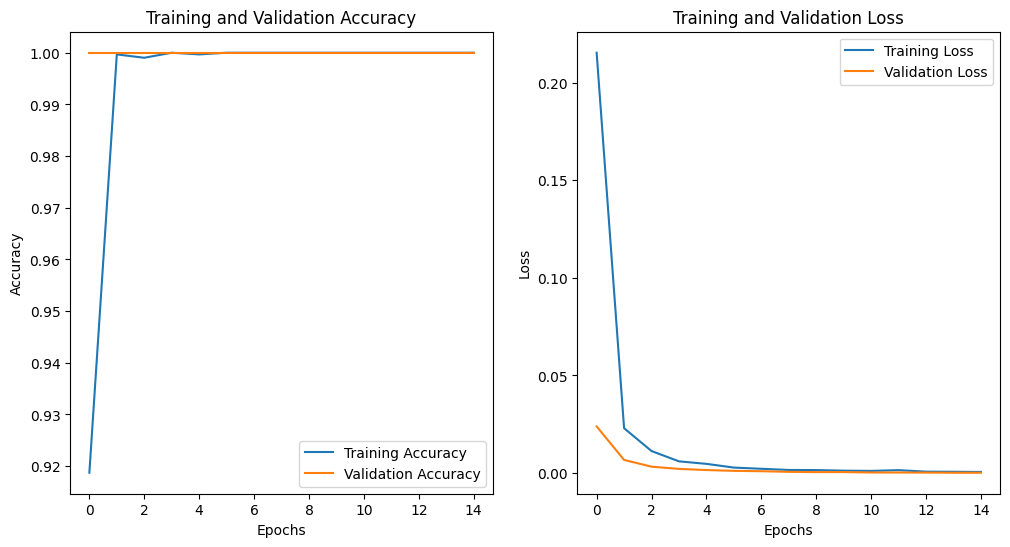

In [62]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Save the trained PCOS model
pcos_model.save('/kaggle/working/pcos_model.h5')


In [ ]:
usg_classifier.save('/kaggle/working/usg_classifier.h5')